In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py, json

from scipy import stats
from sessions import *
from session.adapters import H5NAMES

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = selected_013608
#sessions = selected_013829
#sessions = selected_009265
    
sessions

['013608_ppcSIT_2025-01-06_13-20-52',
 '013608_ppcSIT_2025-01-07_08-47-27',
 '013608_ppcSIT_2025-01-07_15-38-23',
 '013608_ppcSIT_2025-01-09_09-09-55',
 '013608_ppcSIT_2025-01-10_09-25-04',
 '013608_ppcSIT_2025-01-13_14-01-40',
 '013608_ppcSIT_2025-01-14_10-20-14',
 '013608_ppcSIT_2025-01-15_14-56-18',
 '013608_ppcSIT_2025-01-16_09-49-21',
 '013608_ppcSIT_2025-01-17_10-07-00',
 '013608_ppcSIT_2025-01-20_09-38-20',
 '013608_ppcSIT_2025-01-21_08-50-02',
 '013608_ppcSIT_2025-01-22_12-59-00',
 '013608_ppcSIT_2025-01-23_08-46-51',
 '013608_ppcSIT_2025-01-24_08-19-45',
 '013608_ppcSIT_2025-01-27_09-00-20']

In [15]:
# collecting unit numbers
# for 57: 9 shanks
shank_count = 6
s_names = ['units', 'descendants', 'AEPs', 'bMAPs', 'nMAPs', 'nMAP_seg']
f_names = ['units.h5', 'descendants.h5', 'AEPs.h5', 'analysis/MoSeq_tSNE_UMAP.h5', \
           'analysis/W1-W4_tSNE_UMAP.h5', 'analysis/nMAP_segmentation.h5']

unit_mx = np.zeros([len(sessions), shank_count], dtype=np.int16)
performance = np.zeros(len(sessions))
tgt_freqs   = np.zeros(len(sessions))
tgt_durs    = np.zeros(len(sessions))
file_status = np.zeros([len(sessions), len(s_names)])

for i, session in enumerate(sessions):
    animal      = session.split('_')[0]
    meta_file   = os.path.join(source, animal, session, 'meta.h5')
    units_file  = os.path.join(source, animal, session, 'units.h5')

    # performance and target freq / duration
    with h5py.File(meta_file, 'r') as f:
        trials = np.array(f['processed']['trial_idxs'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_freqs[i] = cfg['sound']['sounds']['target']['freq']
    tgt_durs[i]  = cfg['sound']['sounds']['target']['duration']
        
    tr_succ = trials[trials[:, 5] == 1]
    performance[i] = len(tr_succ) / (len(trials))
    
    for j, name in enumerate(f_names):
        if os.path.exists(os.path.join(source, animal, session, name)):
            file_status[i][j] = 1
    
    if file_status[i][0] == 0:
        print("Session %s - no units" % session)
        continue

    # unit count        
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]

    shanks = np.unique([int(x[0]) for x in unit_names])
    shanks.sort()
    
    for shank in shanks:
        unit_mx[i, shank - 1] = len([x for x in unit_names if int(x[0]) == shank])

In [16]:
# detected shanks
shanks

array([1, 2, 3, 5, 6])

In [17]:
pd.set_option('display.max_columns', None)

df = pd.DataFrame()
#df['session'] = [s[-19:-6] for s in sessions]
df['session'] = sessions

el_shank_names = [el for el in range(unit_mx.shape[1])]
for i in el_shank_names:
    df[str(i + 1)] = unit_mx[:, i]
    
# dual implants
df['A1'] = df[[str(i+1) for i in el_shank_names[:1]]].sum(axis=1)
df['PPC'] = df[[str(i+1) for i in el_shank_names[1:]]].sum(axis=1)

# Neuropixels
#df['Total'] = df[[str(i+1) for i in el_shank_names]].sum(axis=1)
    
df['performance'] = np.round(performance, 3)
df['frequency']   = tgt_freqs.astype(np.int16)
df['duration']    = 1000*tgt_durs
for i, name in enumerate(s_names):
    df[name] = file_status[:, i]

df[:50]
#df[(df['duration'] > 60) & (df['performance'] > 0.5) & (df['PPC'] > 0)]

,session,1,2,3,4,5,6,A1,PPC,performance,frequency,duration,units,descendants,AEPs,bMAPs,nMAPs,nMAP_seg
0,009265_hippoSIT_2023-02-28_13-16-10,6,9,0,7,7,0,6,23,0.579,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
1,009265_hippoSIT_2023-02-28_20-45-04,11,3,0,1,3,4,11,11,0.444,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
2,009265_hippoSIT_2023-03-01_10-46-12,3,2,0,1,0,3,3,6,0.333,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
3,009265_hippoSIT_2023-03-02_09-32-54,4,0,0,0,14,5,4,19,0.727,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
4,009265_hippoSIT_2023-03-02_16-27-42,9,8,1,4,11,5,9,29,0.353,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
5,009265_hippoSIT_2023-03-02_20-11-35,16,18,0,3,14,2,16,37,0.590,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
6,009265_hippoSIT_2023-03-03_09-37-07,9,6,0,0,11,2,9,19,0.707,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
7,009265_hippoSIT_2023-03-03_16-00-47,12,9,0,0,9,3,12,21,0.683,660,50.0,1.0,1.0,1.0,1.0,0.0,1.0
8,009265_hippoSIT_2023-03-04_11-12-04,6,6,0,0,5,2,6,13,0.714,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0
9,009265_hippoSIT_2023-03-05_11-52-17,4,6,1,0,0,1,4,8,0.780,660,50.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# 60_SIT_2023-08-31_10-48-38 - A1 - empty, PPC 3 cells, done
# 60_SIT_2023-09-06_09-48-08 - A1 - empty, PPC 4 cells, done
# 60_SIT_2023-09-24_19-04-06 - A1 worth looking, PPC ~one cell, done
# 60_SIT_2023-09-25_19-10-36 - A1 - one cell, PPC nothing, done
# 60_SIT_2023-09-26_19-10-17 - A1 a few cells, PPC a few cells, done
# 60_SIT_2023-09-28_09-55-55 - A1, PPC - something to look at, done
# 60_SIT_2023-11-18_19-12-56 - A1 - empty, PPC - a few cells, done
# 60_SIT_2023-11-24_13-17-01 - A1 - empty, PPC - 15 cells, done

In [8]:
for dur in [57.5, 75, 100, 150]:
    print(df[df['duration'] == dur]['performance'].mean())

nan
nan
nan
nan


In [8]:
df[df['duration'] == 57.5]['0'].sum()

64

## Unit to S1 correlations

In [8]:
#selected = sessions[:]

selected = [
    "60_SIT_2023-09-26_19-10-17",
    "60_SIT_2023-09-28_09-55-55"
]

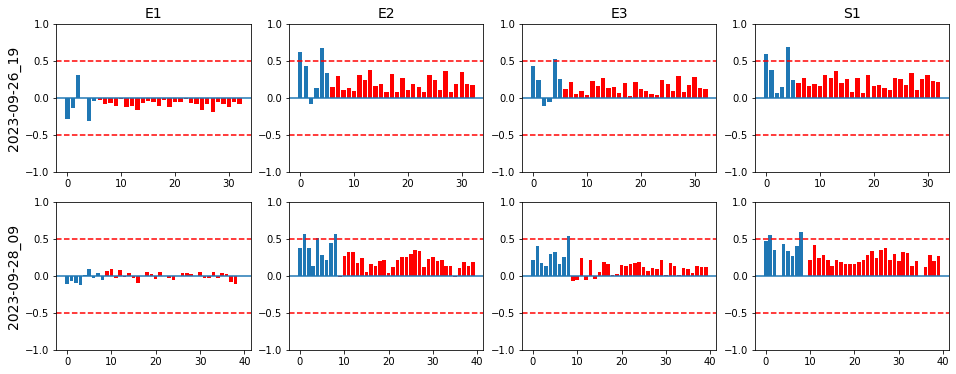

In [9]:
titles = ['E1', 'E2', 'E3', 'S1']
rows = len(selected)
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, rows*3))

for i, session in enumerate(selected):
    animal     = session.split('_')[0]
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    units_file = os.path.join(source, animal, session, 'units.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        w_mx = np.array(f['w_mx'])

    # load units
    unit_names, single_units, spike_times = [], {}, {}
    with h5py.File(units_file, 'r') as f:
        unit_names = [x for x in f]
    with h5py.File(units_file, 'r') as f:
        for unit_name in unit_names:
            spike_times[unit_name] = np.array(f[unit_name][H5NAMES.spike_times['name']])
            single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
        
    results = np.zeros([len(unit_names), 4])
    for j, unit_name in enumerate(unit_names):
        for phase in range(4):
            i_rate_ev = single_units[unit_name][events[:, 2].astype(np.int32)]
            results[j][phase] = stats.pearsonr(i_rate_ev, w_mx[:, phase])[0]
    
    for j in range(4):
        colors = ['tab:blue' if int(unit_name[0]) < 3 else 'red' for unit_name in unit_names]
        ax = axes[i][j]
        ax.bar(np.arange(len(unit_names)), results[:, j], color=colors)
        ax.set_ylim(-1, 1)
        ax.axhline(-0.5, color='red', ls='--')
        ax.axhline(0.5, color='red', ls='--')
        ax.axhline(0)
        if i == 0:
            ax.set_title(titles[j], fontsize=14)
        if j == 0:
            ax.set_ylabel(session[-19:-6], fontsize=14)
        
    #if session == '57_SIT_2024-01-05_14-35-49':
    #    break

## Unit depth

In [50]:
# auditory-responsive thalamic units
thal_units = {
    1: [0, 18, 44, 69, 86, 129, 174, 198, 199, 230, 302, 365, 381, 452, 463, 477, 536, 576],
    2: [102, 131, 189, 218, 232, 248, 264, 276, 278, 280, 305, 369, 385, 395, 406, 408, 410, 411, 412, 425, 428, 501, 528, 613, 625],
    3: [49, 146, 156, 267, 374, 569, 616, 631],
    4: [9, 10, 30, 57, 76, 79, 92, 93, 109, 172, 211, 294, 295, 298, 434, 460, 546, 548, 561, 572, 587, 588, 599, 621],
}

In [84]:
np.arange(0, 360, 15)

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345])

In [85]:
config = {
    1: [[0, 360], [2690, 3050]],
    2: [[400, 760], [760, 1120], [2000, 2360], [2500, 2860], [3320, 3680], [4050, 4410]],
    3: [[1900, 2260], [2740, 3100]],
    4: [[0, 360], [360, 720], [720, 1080], [1800, 2260], [2600, 2960], [3500, 3860]],
}

In [96]:
session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC
#session = '013608_ppcSIT_2025-01-24_08-19-45'  # Thalamus

animal  = session.split('_')[0]

units_file = os.path.join(source, animal, session, 'units.h5')

positions = {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        positions[unit_name] = np.array(f[unit_name]['anatomical_position'])

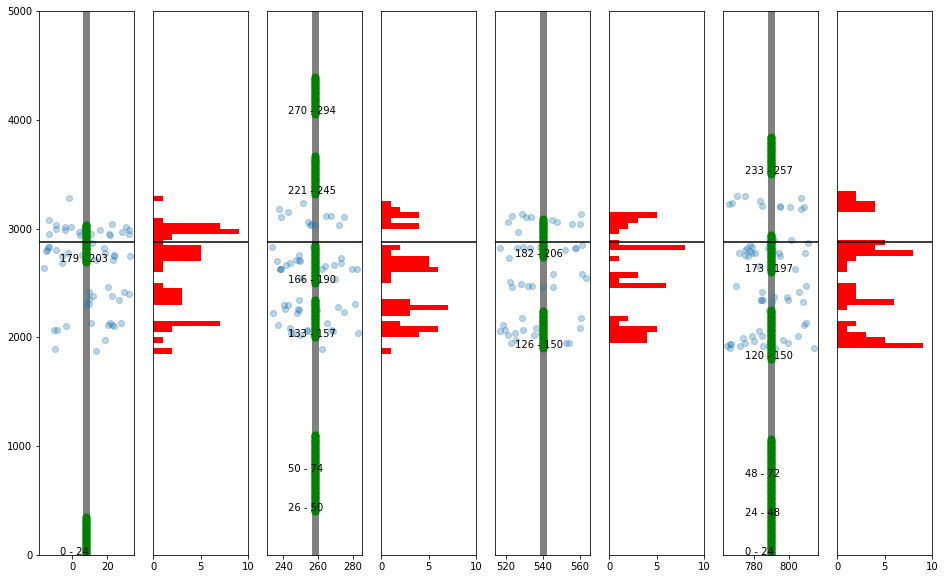

In [98]:
spread = 50
v_max = 5000

fig, axes = plt.subplots(1, 8, figsize=(16, 10))

# probe
x = np.array([8, 258, 540, 790])
y = np.arange(0, 15*640)

for i, x_pos in enumerate(x):
    ids = np.array(thal_units[i+1])
    anat_pos_oth = np.array([pos for unit_id, pos in positions.items() if np.abs(pos[0] - x_pos) < 50])
    anat_pos_sel = np.array([pos for unit_id, pos in positions.items() if np.abs(pos[0] - x_pos) < 50 and \
                             int(unit_id.split('-')[1]) in ids])
    x_pos_oth = np.random.rand(len(anat_pos_oth)) * spread - spread/2
    x_pos_sel = np.random.rand(len(anat_pos_sel)) * spread - spread/2
    
    # probe shank
    axes[2*i].scatter(np.ones(len(y)) * x_pos, y, color='grey')  # probe shank
    axes[2*i].scatter(x_pos_oth + x_pos, anat_pos_oth[:, 1], alpha=0.3, color='tab:blue')
    #axes[2*i].scatter(x_pos_sel + x_pos, anat_pos_sel[:, 1], alpha=0.3, color='red')
    axes[2*i].set_ylim(0, v_max)
    axes[2*i].axhline(15*192, color='black')
    if i > 0:
        axes[2*i].set_yticks([])
    
    for band in config[i+1]:
        y_band = np.arange(band[0], band[1], 15)
        axes[2*i].scatter(np.ones(len(y_band)) * x_pos, y_band, s=50, color='green') 
        axes[2*i].text(x_pos - 15, band[0], '%d - %d' % (band[0]/15, band[1]/15))
    
    
    # unit density
    axes[2*i+1].hist(anat_pos_oth[:, 1], bins=np.arange(0, v_max, 50), color='red', orientation="horizontal")
    axes[2*i+1].set_xlim(0, 10)
    axes[2*i+1].set_ylim(0, v_max)
    axes[2*i+1].axhline(15*192, color='black')
    axes[2*i+1].set_yticks([])

## Touch files for snakemake 

In [20]:
import subprocess

animal = '009265'

for session in os.listdir(os.path.join(source, animal)):
    dlc_path = os.path.join(source, animal, session, 'dlc')
    if os.path.exists(dlc_path):
        subprocess.run(['touch ' + os.path.join(dlc_path, '*')], shell=True)
    moseq_path = os.path.join(source, animal, session, 'moseq')
    if os.path.exists(moseq_path):
        print(moseq_path)
        subprocess.run(['touch ' + os.path.join(moseq_path, '*')], shell=True)

/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-03_16-00-47/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-03_09-37-07/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-02_16-27-42/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-02-24_17-22-46/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-02_09-32-54/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-02-28_09-16-50/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-08_18-10-07/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-10_09-57-34/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-02-24_09-53-26/moseq
/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-01_10-46-12/moseq
/home/sobolev/nevermind/AG_Pec

touch: setting times of '/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-05_11-52-17/dlc/videoDLC_resnet50_implantedSITJun23shuffle3_960000.csv': Permission denied
touch: setting times of '/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-05_11-52-17/dlc/videoDLC_resnet50_implantedSITJun23shuffle3_960000.h5': Permission denied
touch: setting times of '/home/sobolev/nevermind/AG_Pecka/data/processed/009265/009265_hippoSIT_2023-03-05_11-52-17/dlc/videoDLC_resnet50_implantedSITJun23shuffle3_960000_meta.pickle': Permission denied


In [99]:
raw_session_path = '/storage3/eva/data/raw/eb01/OE/2025-01-24_16-49-37'
processed_session_path = '/storage3/eva/data/processed/eb01/OE/2025-01-24_16-49-37'

raw_session_path.split('/')

['', 'storage3', 'eva', 'data', 'raw', 'eb01', 'OE', '2025-01-24_16-49-37']

In [9]:
h5p = '/home/sobolev/nevermind/AG_Pecka/data/processed/013829/013829_ppcSIT_2024-11-16_11-17-54/analysis/population_matrices.h5'

with h5py.File(h5p, 'r') as f:
    ev_bin_count = np.array(f['ev_bin_count'])


In [12]:
int(ev_bin_count)

12